Animating oil dispersion on the Salish Sea Atlantis grid. Original code written by Bec Gordon & Javier Porobic, CSIRO, modified to create an animated GIF

In [98]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

In [43]:
# salish sea atlantis box shapefile.
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(shapefile_name)
data_df = data_df.sort_values(by=['BOX_ID'])
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]


In [39]:
# Reading in the file generated by Ocean Parcels

scenario = '5b TurnPoint Dilbit'
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/5b_TurnPoint_Control/outputSalishSea.nc"
data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/5b_TurnPoint_BranchCode/outputSalishSea.nc"

# data
control = xr.open_dataset(str(control_file), decode_cf=True)
data = xr.open_dataset(str(data_file), decode_cf=True)

# time
control_time = np.ma.filled(control.variables['t'], np.nan)
oiled_time = np.ma.filled(data.variables['t'], np.nan)


In [4]:
def box_total(data, control, species):
    
    data_all = np.ma.filled(data.variables[species][:,:,:], np.nan)
    data_all_depths = data_all.sum(axis=2)
    
    control_all = np.ma.filled(control.variables[species][:,:,:], np.nan)
    control_all_depths = control_all.sum(axis=2)

    return data_all_depths, control_all_depths

def model_total(data, control, species):
    
    data_all = np.ma.filled(data.variables[species], np.nan)
    data_all_depths = data_all.sum(axis=2)
    data_all_boxes = data_all_depths.sum(axis=1)
    
    control_all = np.ma.filled(control.variables[species], np.nan)
    control_all_depths = control_all.sum(axis=2)
    control_all_boxes = control_all_depths.sum(axis=1)

    return data_all_boxes, control_all_boxes

def cohort_total_perbox(data, species_name, numCohorts):

    numbers = np.ma.zeros((data.variables[species_name + '1_Nums'].shape),dtype = np.int32)
    structuralN = np.ma.zeros((data.variables[species_name + '1_Nums'].shape),dtype = np.int32)
    reservedN = np.ma.zeros((data.variables[species_name + '1_Nums'].shape),dtype = np.int32)

    for cohort in range (1, numCohorts+1):

        species = species_name + str(cohort)
        
        numbers = numbers + np.ma.filled(data.variables[species + '_Nums'][:,:,:], np.nan)
        structuralN = structuralN + np.ma.filled(data.variables[species +'_StructN'][:,:,:], np.nan)
        reservedN = reservedN + np.ma.filled(data.variables[species +'_ResN'][:,:,:], np.nan)

    numbers = numbers.sum(axis=2)
    structuralN = structuralN.sum(axis=2)
    reservedN = reservedN.sum(axis=2)
    
    return numbers, structuralN, reservedN 


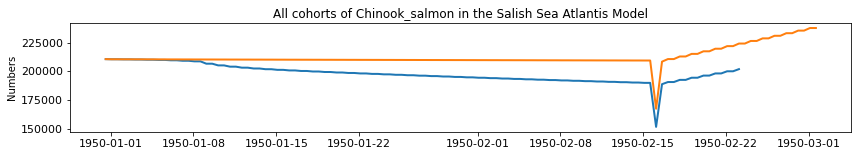

In [8]:
# Age-structured species
species = 'Chinook_salmon'
numCohorts = 5

num_oiled, sN_oiled, rN_oiled = cohort_total_perbox(data, species, numCohorts)
num_control, sN_control, rN_control = cohort_total_perbox(control, species, numCohorts)

model_numbers_oiled = num_oiled.sum(axis=1)
model_numbers_control = num_control.sum(axis=1)

label_size = 11
font_size = 12
line_width = 2

fig, ax = plt.subplots(figsize = (14,2))
ax.plot(oiled_time, model_numbers_oiled, control_time, model_numbers_control, linewidth = line_width)
ax.set_title('All cohorts of ' + species + ' in the Salish Sea Atlantis Model', fontsize = font_size)
ax.set_ylabel('Numbers')
ax.tick_params(labelsize=label_size)

In [15]:
np.max(model_numbers_control)

237617.2958729692

In [ ]:
data_num, control_num = box_total(data, control, species + '_Nums')
data_sN, control_sN = box_total(data, control, species +'_StructN')
data_rN, control_rN = box_total(data, control, species +'_ResN')
time = np.ma.filled(data.variables['t'], np.nan)

In [44]:
_cmap = cm.coolwarm #winter #viridis #Paired
file_names = []

land_df = data_df.loc[land_boxes]
num_steps = oiled_time.shape[0]
v_min = np.min(num_oiled[-1])
v_max = np.max(num_control[-1])/2

for time_index in range(0, num_steps):
   
    time_oil = num_oiled[time_index][:]
    time_control = num_control[time_index][:]
    
    data_df['oiled'] = time_oil
    data_df['control'] = time_control
    data_df.loc[land_boxes, 'oiled'] = 0

    ax = data_df.plot(figsize=(9, 15), column = 'oiled', cmap=_cmap,
        vmin=v_min, vmax=v_max,
        legend=True, legend_kwds={'label': "Change in number of " + species
        },)

    land_df.plot(ax=ax, color='white')
    ax.set_title(oiled_time[time_index])

    #plt.tight_layout()
    plot_name = species + '_time_' + str(time_index).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

In [165]:
## COPY OF CELL ABOVE FOR TESTING PURPOSES
_cmap = cm.twilight_shifted #winter #viridis #Paired bwr  coolwarm_r
file_names = []

land_df = data_df.loc[land_boxes]
num_steps = oiled_time.shape[0]
v_min = np.min(num_oiled[-1])
v_max = np.max(num_control[-1])/3

n_min = np.min(model_numbers_oiled)
n_max = np.max(model_numbers_control)

for time_index in range(0, 20):
   
    time_oil = num_oiled[time_index][:]
    time_control = num_control[time_index][:]
    ts_date = pd.to_datetime(str(oiled_time[time_index]))
    spill_date = pd.to_datetime(str(oiled_time[13]))
    
    data_df['oiled'] = time_oil
    data_df['control'] = (time_oil - time_control) / time_control * 100
    data_df.loc[land_boxes, 'oiled'] = 0

    fig = plt.figure(figsize=(18, 15))
    gs = plt.GridSpec(2, 2, wspace=0.1, hspace=0.2, width_ratios=[9, 9], height_ratios=[1, 4])

    ax_ts = fig.add_subplot(gs[0, :])
    ax_ts.plot(oiled_time, model_numbers_oiled, control_time, model_numbers_control, linewidth = line_width)
    ax_ts.plot([ts_date, ts_date], [n_min, n_max], 'k--')
    ax_ts.plot([spill_date, spill_date], [n_min, n_max], 'r')
    ax_ts.set_title('All cohorts of ' + species + ' across the Salish Sea Atlantis Model', fontsize = font_size)
    ax_ts.set_ylabel('Numbers')
    ax_ts.legend(('with oil', 'without oil'), loc='lower left')

    ax = fig.add_subplot(gs[1, 0])
    ax = data_df.plot(column='oiled', vmin=v_min, vmax=v_max, ax=ax, legend=True,
    legend_kwds={'label': "Number of " + species
                },)  
    #ax.set_title(oiled_time[time_index])  
    land_df.plot(ax=ax, color='white')   

    ax = fig.add_subplot(gs[1, 1])
    ax = data_df.plot(column='control', cmap=_cmap, vmin=-50, vmax=50, ax=ax, legend=True,
    legend_kwds={'label': "Percent change in number of " + species
                 },)
    #ax.set_title(oiled_time[time_index])
    land_df.plot(ax=ax, color='white') 
    
    
    #plt.tight_layout()
    plot_name = species + '_time_' + str(time_index).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

In [166]:
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("*.png")
imgs.sort() 
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)


# Save into loop
anim_name = str(scenario) + '_' + species +'.gif'
frames[0].save(anim_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

file_name_str = ' '.join(file_names)
os.system('rm ' + file_name_str)

0

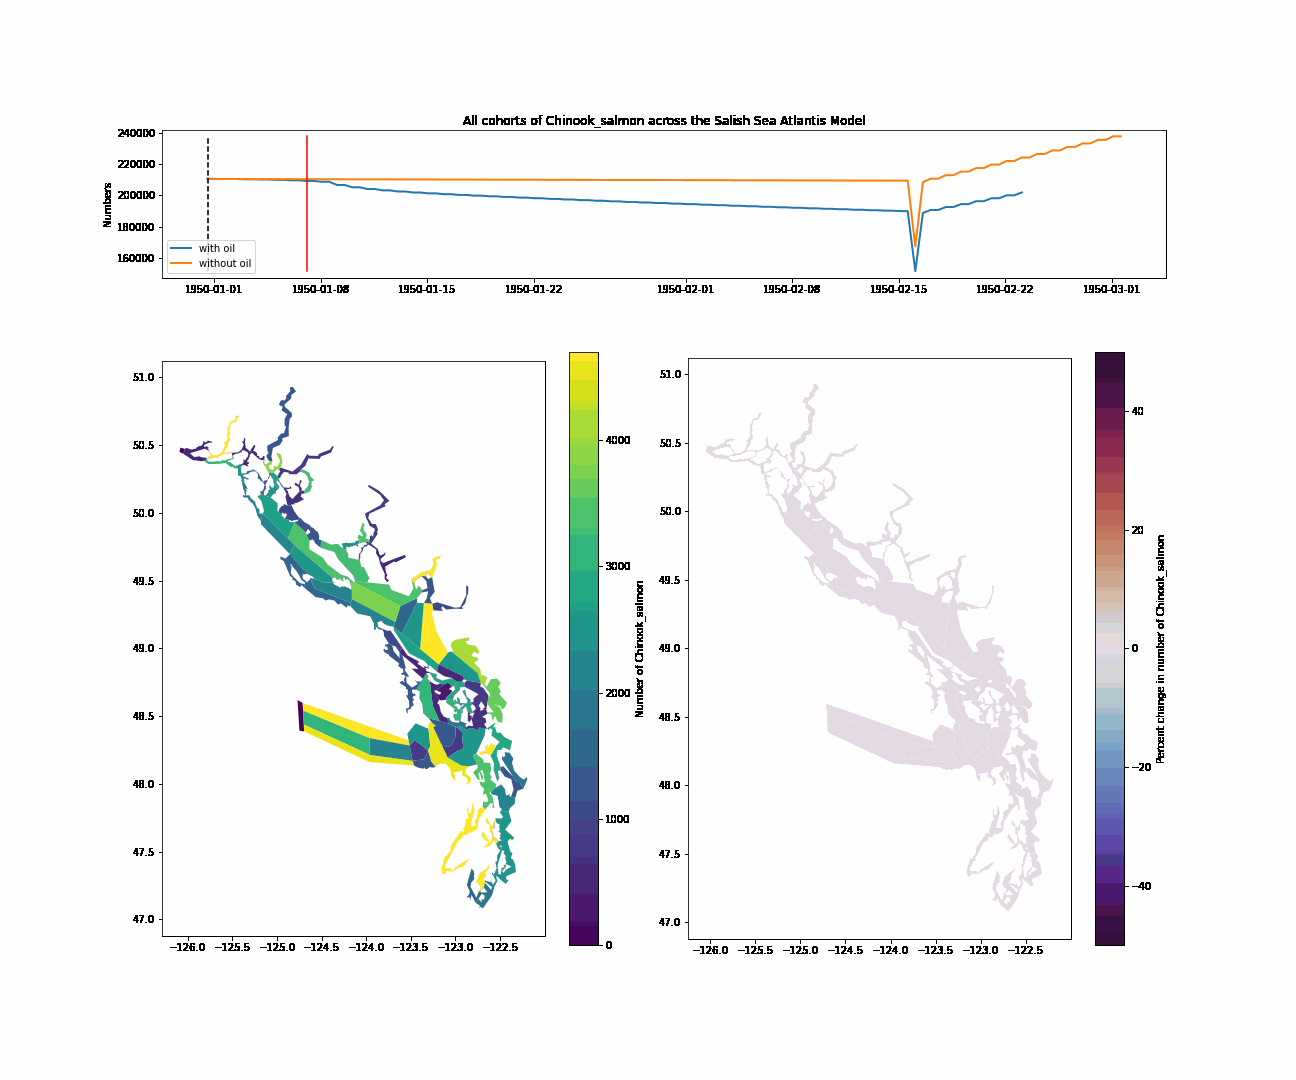

In [167]:
from IPython.display import Image
with open(anim_name,'rb') as anim:
    display(Image(anim.read()))